In [1]:
import sys
import csv
import os
sys.path.insert(0, '..')
import ecoscape_connectivity
from scgt import GeoTiff, Tile
import time
import torch
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [3]:
device = (torch.device('cuda') if torch.cuda.is_available() else 
          torch.device('mps') if torch.backends.mps.is_available() else
          torch.device('cpu'))
device

device(type='cuda')

In [4]:
DATA_PATH="assets"

HABITAT_PATH = os.path.join(DATA_PATH, "habitat_CA.tif")
LANDCOVER_PATH = os.path.join(DATA_PATH, "terrain_CA.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "permeability_CA.csv")


In [5]:
with open(PERMEABILITY_PATH, mode='r') as infile:
    reader = csv.reader(infile)
    permeability_dict = {rows[0]:rows[1] for rows in reader}

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "Outputs/connectivity_CA.tif")
FLOW_PATH = os.path.join(DATA_PATH, "Outputs/flow_CA.tif")


## Luca Diagonal 2 Method

In [6]:
def repopulate(hab, ter, num_spreads=40, spread_size=1, device=device, simulations=100, display=False):
    repopulator = ecoscape_connectivity.RandomPropagate_diagonal_luca(
        hab, ter, 
        num_spreads=40, 
        spread_size=1, device=device).to(device)
    seeds = torch.zeros((simulations, 100, 100))
    seeds[:, 50, 50] = 1
    seeds = seeds.to(device)
    pop = repopulator(seeds)
    pop = torch.mean(pop, 0)
    a = pop.cpu().detach().numpy()
    if display:
        plt.figure(figsize=(8, 8))
        plt.imshow(a, cmap='inferno')
        plt.colorbar(shrink=0.6)
        plt.show()
        tot_pop = pop.sum()
        tot_pop.backward()
        flow = repopulator.get_grad()
        flow = flow.cpu().detach().numpy()
        plt.figure(figsize=(8, 8))
        plt.imshow(flow, cmap='inferno')
        plt.colorbar(shrink=0.6)
    return a

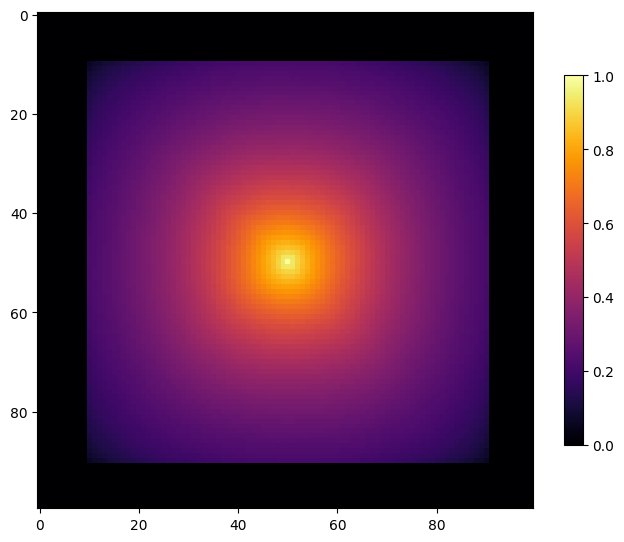

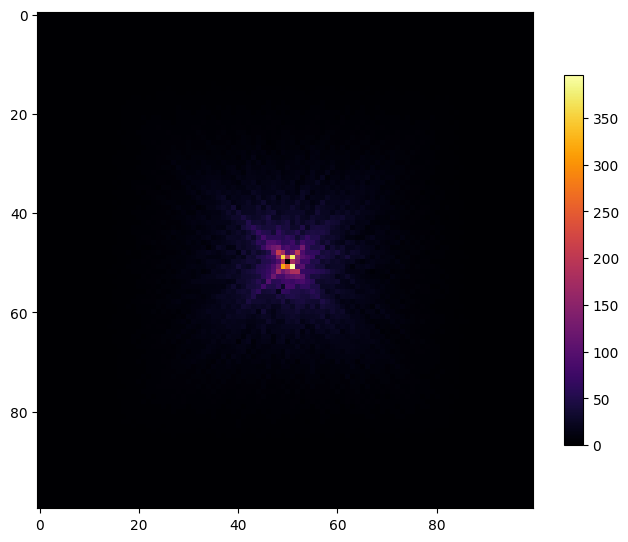

In [10]:
simulations = 100
hab = torch.ones((100, 100), device=device)
hab[50,50] = 1
ter = torch.ones((100, 100), device=device)*0.97
repopulate(hab, ter, display=True, simulations=100)
plt.show()

Time: 117.87309694290161
(1, 189, 233)


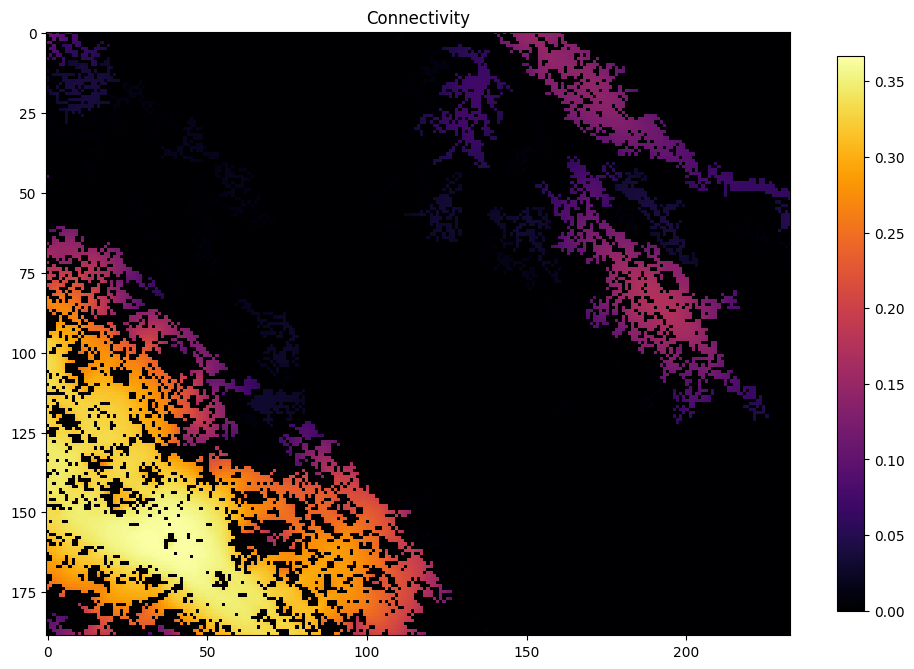

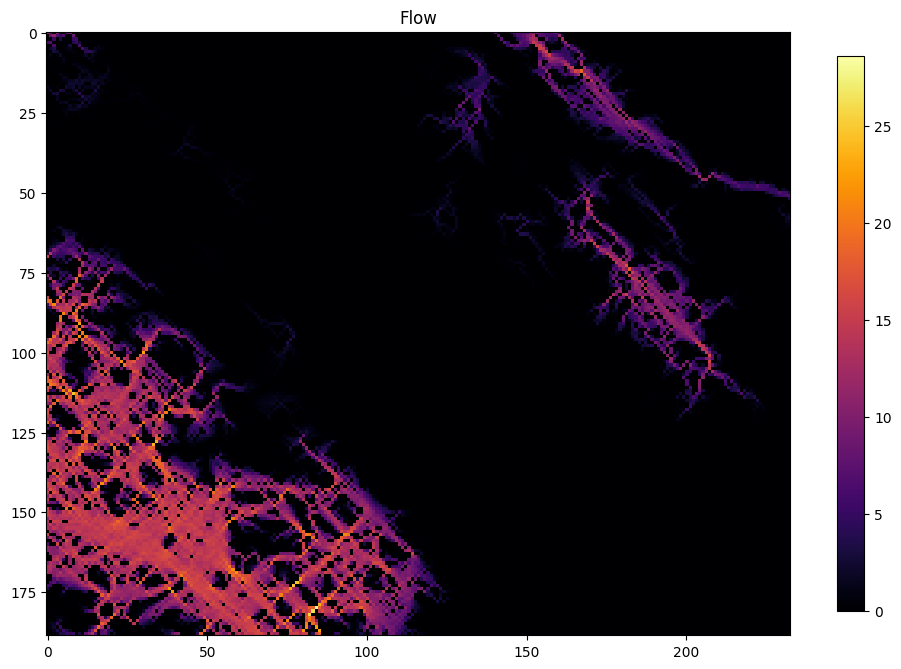

In [8]:
t = time.time()
ecoscape_connectivity.compute_connectivity_diagonal_luca(
    habitat_fn=HABITAT_PATH,
    landcover_fn=LANDCOVER_PATH,
    permeability_dict=permeability_dict,
    connectivity_fn=CONNECTIVITY_PATH,
    flow_fn=FLOW_PATH,
    single_tile=True,
    border_size=50,
    num_simulations=2000,
    include_border=False,
    dispersal=50, # ecoscape_connectivity.half_cauchy(10, 40),
    device=device
)
print("Time:", time.time() - t)
with GeoTiff.from_file(CONNECTIVITY_PATH) as single_connectivity:
# single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title="Connectivity")
with GeoTiff.from_file(FLOW_PATH) as single_flow:
# single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title="Flow")

## Coen Diagonal 2 Method

In [6]:
def repopulate(hab, ter, num_spreads=40, spread_size=1, device=device, diagonal_coef=0.99, simulations=100, display=False):
    repopulator = ecoscape_connectivity.RandomPropagate_diagonal(
        hab, ter, 
        num_spreads=40, 
        spread_size=1, device=device, 
        diagonal_coef=diagonal_coef).to(device)
    seeds = torch.zeros((simulations, 100, 100))
    seeds[:, 50, 50] = 1
    seeds = seeds.to(device)
    pop = repopulator(seeds)
    pop = torch.mean(pop, 0)
    a = pop.cpu().detach().numpy()
    if display:
        plt.figure(figsize=(8, 8))
        plt.imshow(a, cmap='inferno')
        plt.colorbar(shrink=0.6)
        plt.show()
        tot_pop = pop.sum()
        tot_pop.backward()
        flow = repopulator.get_grad()
        flow = flow.cpu().detach().numpy()
        plt.figure(figsize=(8, 8))
        plt.imshow(flow, cmap='inferno')
        plt.colorbar(shrink=0.6)
    return a

epoch: 19 diff: 0.000 coef: 0.97298 vert: 0.359 diag: 0.359


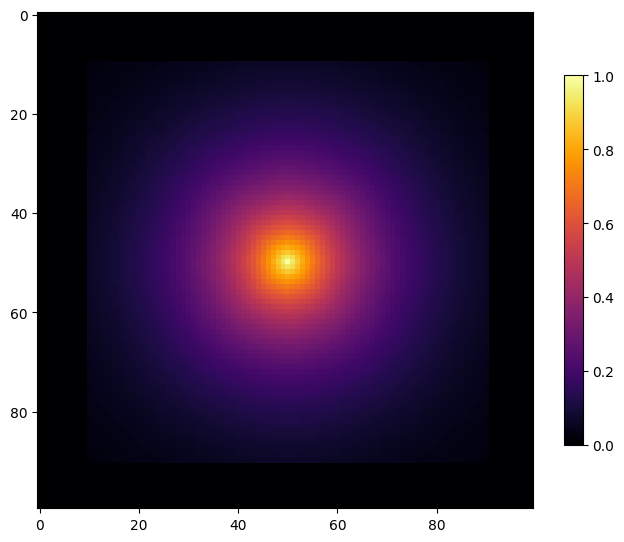

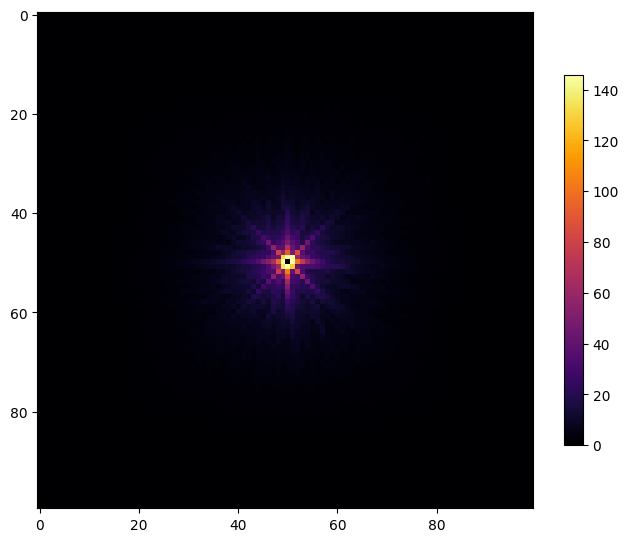

In [12]:
# Diagonal Coefficient Optimization
# Make sure to comment out x *= self.habitat in the forward pass of the propation module
simulations = 100
hab = torch.zeros((100, 100), device=device)
hab[50,50] = 1
ter = torch.ones((100, 100), device=device)*0.95
diagonal_coef = 0.99
for i in range(20):
    a = repopulate(hab, ter, diagonal_coef=diagonal_coef)
    vertical_mean = np.mean(a[50:90,50])
    y = a.diagonal()[50:90]
    x = np.array(range(len(y))) * 2**0.5

    poly = PolynomialFeatures(degree=4)
    X_poly = poly.fit_transform(x.reshape(-1, 1))
    
    poly.fit(X_poly, y)
    lin2 = LinearRegression()
    lin2.fit(X_poly, y)
    x_pred = np.array(range(40))
    y_pred = lin2.predict(poly.fit_transform(x_pred.reshape(-1,1)))
    diagonal_mean = np.mean(y_pred)

    diagonal_coef += 0.001*2.71**(-i/20)*(vertical_mean-diagonal_mean)*100
print(f"epoch: {i} diff: {(vertical_mean-diagonal_mean):.3f} coef: {diagonal_coef:.5f} vert: {vertical_mean:.3f} diag: {diagonal_mean:.3f}")
repopulate(hab, ter, diagonal_coef=diagonal_coef, display=True, simulations=100)
plt.show()

0.28850187752879664 0.24975276787704548


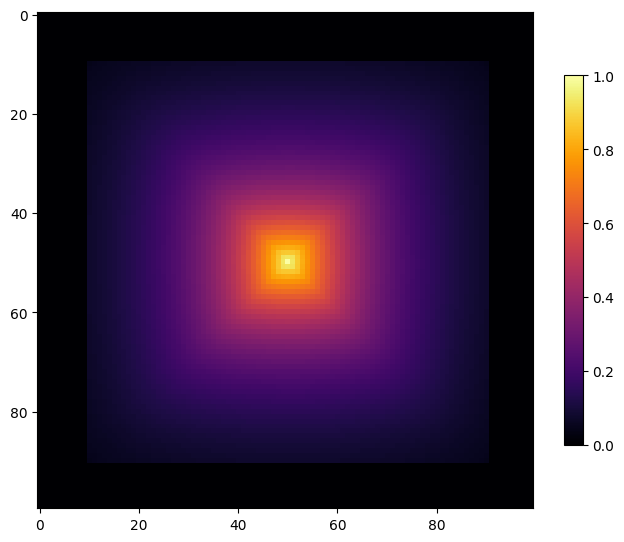

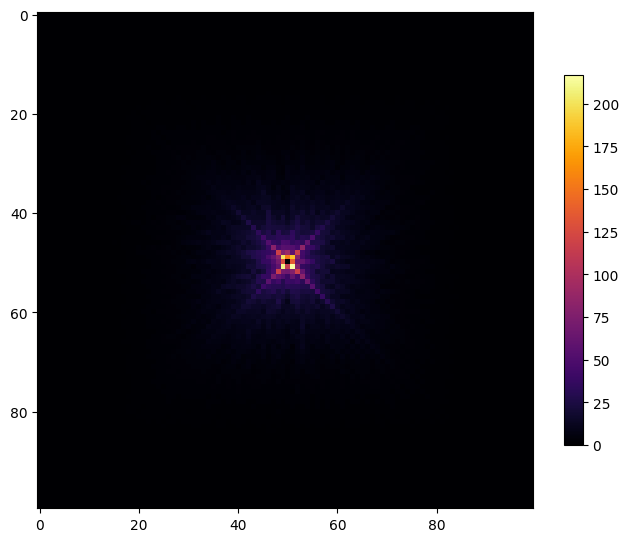

In [11]:
simulations = 100
hab = torch.zeros((100, 100), device=device)
hab[50,50] = 1
ter = torch.ones((100, 100), device=device)*0.95
diagonal_coef = 0.99158 
repopulator = ecoscape_connectivity.RandomPropagate_diagonal(
    hab, ter, 
    num_spreads=40, 
    spread_size=1, device=device, 
    diagonal_coef=diagonal_coef).to(device)
seeds = torch.zeros((simulations, 100, 100))
seeds[:, 50, 50] = 1
seeds = seeds.to(device)
pop = repopulator(seeds)
pop = torch.mean(pop, 0)
a = pop.cpu().detach().numpy()
vertical_mean = np.mean(a[:,50])
diagonal_mean = np.mean(a.diagonal())
print(vertical_mean, diagonal_mean)
plt.figure(figsize=(8, 8))
plt.imshow(a, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()
tot_pop = pop.sum()
tot_pop.backward()
flow = repopulator.get_grad()
flow = flow.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(flow, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()


Single tile
Time: 89.71348476409912
(1, 189, 233)


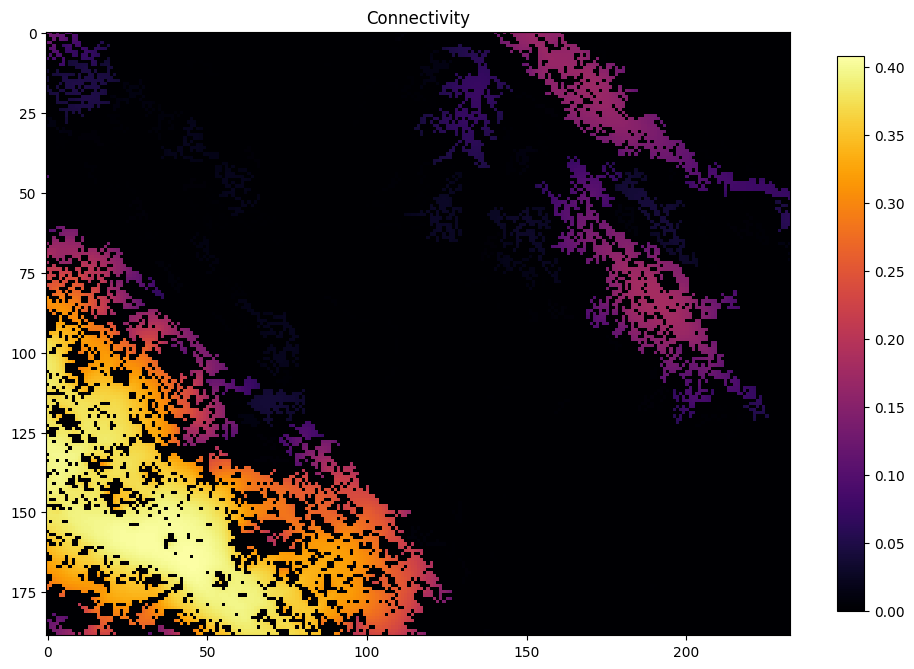

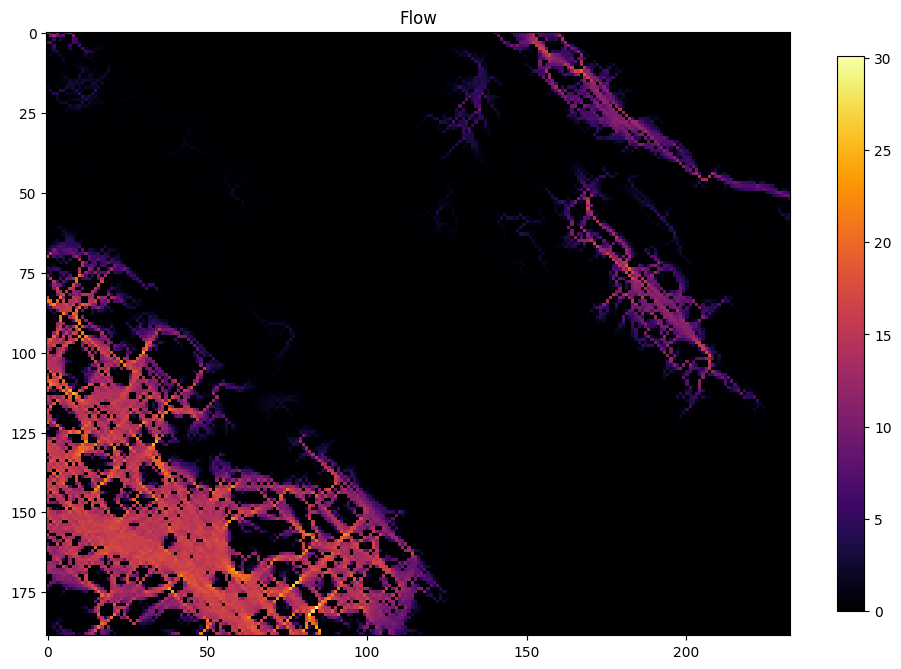

In [9]:
t = time.time()
ecoscape_connectivity.compute_connectivity_diagonal(
    habitat_fn=HABITAT_PATH,
    landcover_fn=LANDCOVER_PATH,
    permeability_dict=permeability_dict,
    connectivity_fn=CONNECTIVITY_PATH,
    flow_fn=FLOW_PATH,
    single_tile=True,
    border_size=50,
    num_simulations=2000,
    include_border=False,
    dispersal=50, # ecoscape_connectivity.half_cauchy(10, 40),
    diagonal_coef=0.99,
    device=device
)
print("Time:", time.time() - t)
with GeoTiff.from_file(CONNECTIVITY_PATH) as single_connectivity:
# single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title="Connectivity")
with GeoTiff.from_file(FLOW_PATH) as single_flow:
# single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title="Flow")

## Infinite flips

New


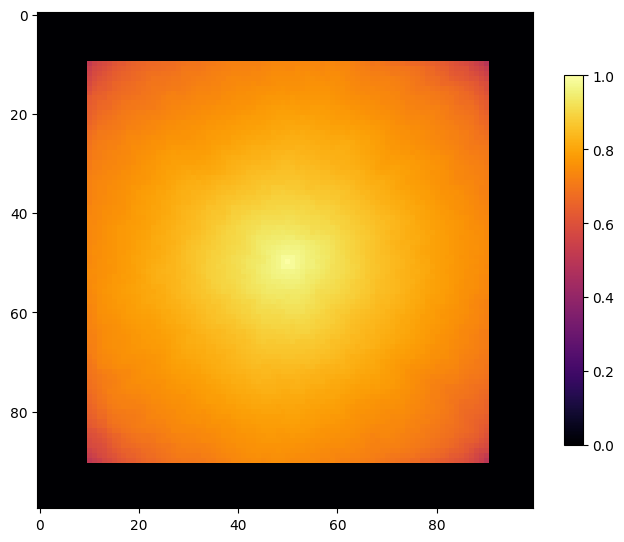

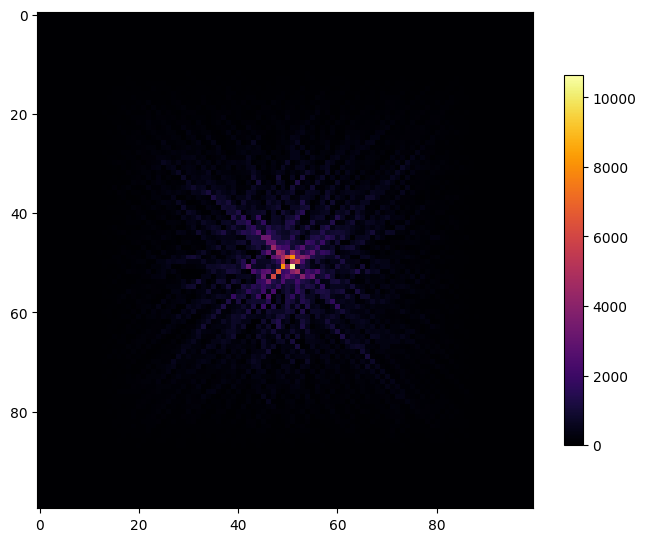

In [13]:

hab = torch.ones((100, 100), device=device)
ter = torch.ones((100, 100), device=device)
repopulator = ecoscape_connectivity.StochasticRepopulateFast(
    hab, ter, 
    num_spreads=40, 
    spread_size=1).to(device)
seeds = torch.zeros((10, 100, 100))
seeds[:, 50, 50] = 1
seeds = seeds.to(device)
pop = repopulator(seeds)
a = np.mean(pop.cpu().detach().numpy(), 0)
plt.figure(figsize=(8, 8))
plt.imshow(a, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()
tot_pop = pop.sum()
tot_pop.backward()
flow = repopulator.get_grad()
flow = flow.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(flow, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()


Single tile
New_9
Time: 291.39264583587646
(1, 189, 233)


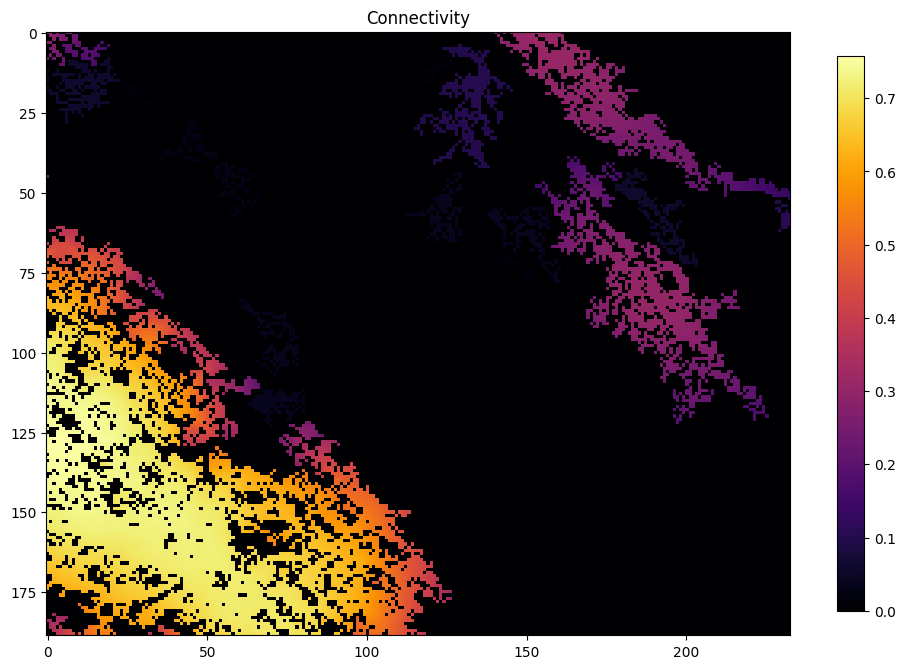

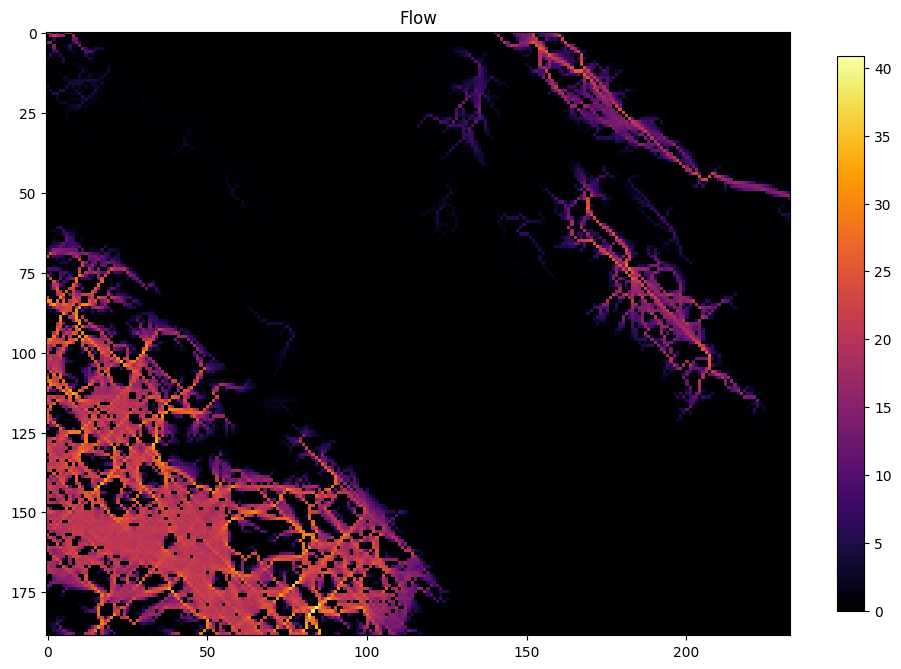

In [12]:
t = time.time()
ecoscape_connectivity.compute_connectivity_9(
    habitat_fn=HABITAT_PATH,
    landcover_fn=LANDCOVER_PATH,
    permeability_dict=permeability_dict,
    connectivity_fn=CONNECTIVITY_PATH,
    flow_fn=FLOW_PATH,
    single_tile=True,
    border_size=50,
    num_simulations=2000,
    include_border=False,
    dispersal=50, # ecoscape_connectivity.half_cauchy(10, 40),
    device=device
)
print("Time:", time.time() - t)
with GeoTiff.from_file(CONNECTIVITY_PATH) as single_connectivity:
# single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title="Connectivity")
with GeoTiff.from_file(FLOW_PATH) as single_flow:
# single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title="Flow")

## Version v3

New


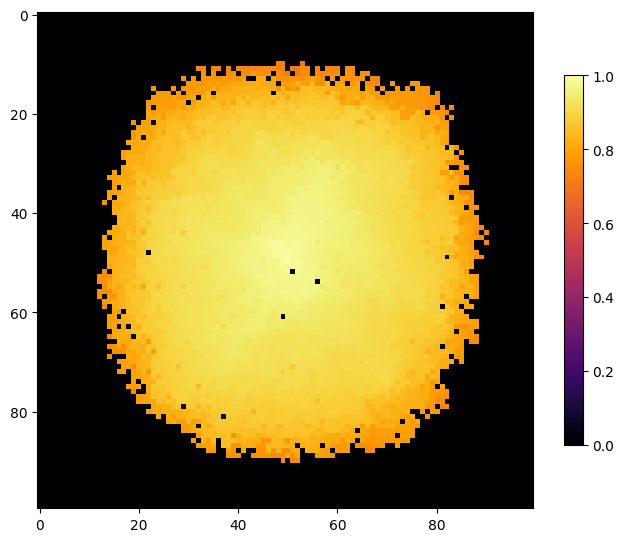

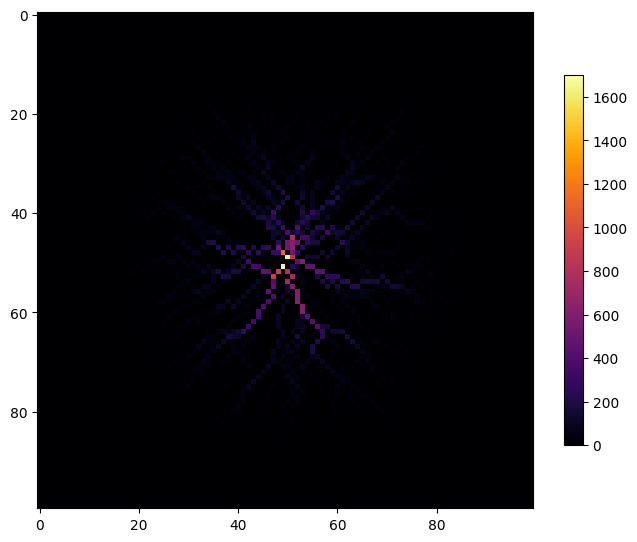

In [6]:

hab = torch.ones((100, 100), device=device)
ter = torch.ones((100, 100), device=device)
repopulator = ecoscape_connectivity.RandomPropagate_v3(
    hab, ter, 
    num_spreads=40, 
    spread_size=1, device=device).to(device)
seeds = torch.zeros((100, 100))
seeds[50, 50] = 1
seeds = seeds.to(device)
pop = repopulator(seeds)
a = pop.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(a, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()
tot_pop = pop.sum()
tot_pop.backward()
flow = repopulator.get_grad()
flow = flow.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(flow, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()


New
Time: 61.04018688201904
(1, 189, 233)


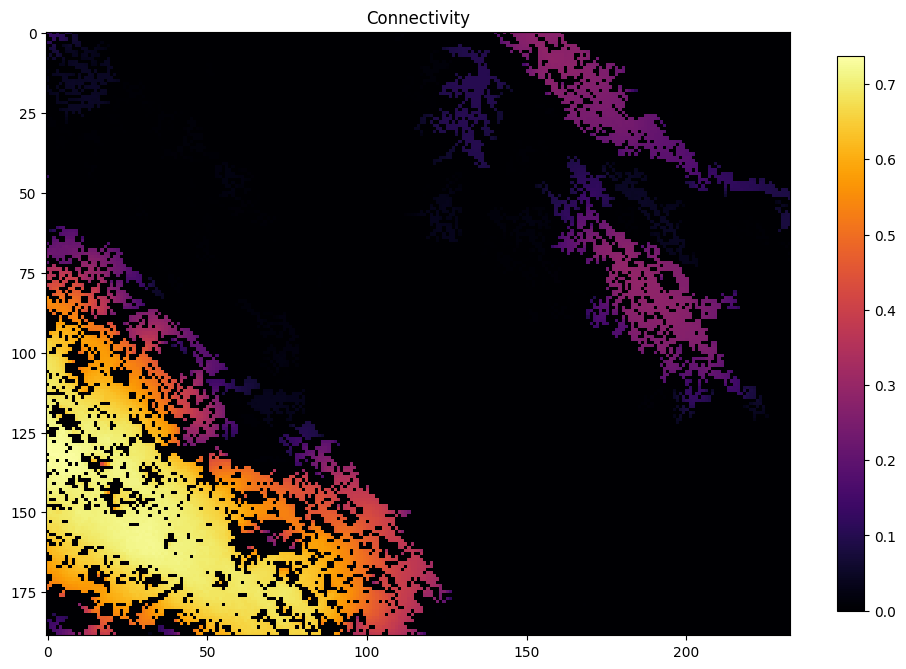

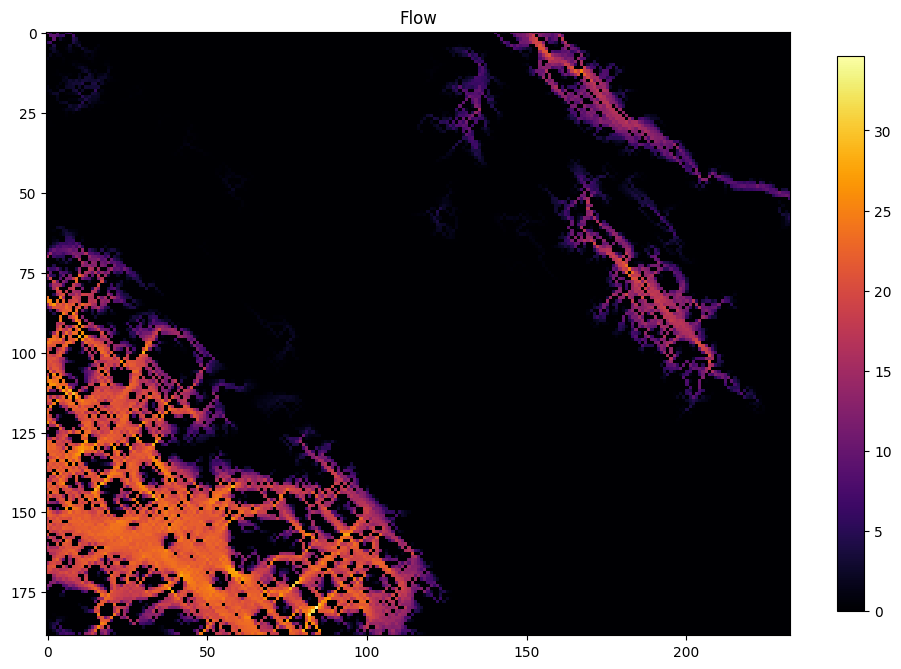

In [10]:
t0 = time.time()
ecoscape_connectivity.compute_connectivity_v3(
    habitat_fn=HABITAT_PATH,
    landcover_fn=LANDCOVER_PATH,
    permeability_dict=permeability_dict,
    connectivity_fn=CONNECTIVITY_PATH,
    flow_fn=FLOW_PATH,
    single_tile=True,
    border_size=50,
    num_simulations=2000,
    include_border=False,
    dispersal=50, # ecoscape_connectivity.half_cauchy(10, 40),
    device=device
)
print("Time:", time.time() - t0)
with GeoTiff.from_file(CONNECTIVITY_PATH) as single_connectivity:
# single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title="Connectivity")
with GeoTiff.from_file(FLOW_PATH) as single_flow:
# single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title="Flow")

## Version v2

New


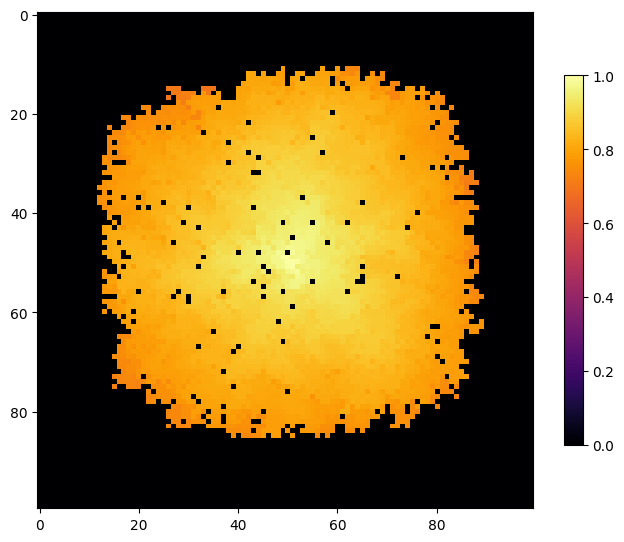

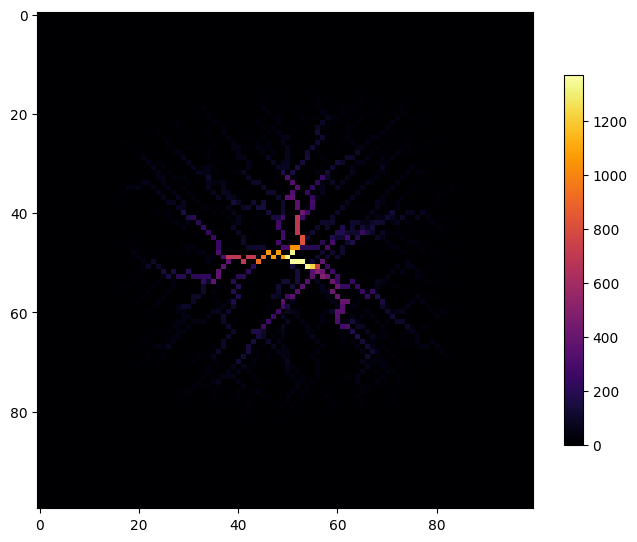

In [9]:

hab = torch.ones((100, 100), device=device)
ter = torch.ones((100, 100), device=device)
repopulator = ecoscape_connectivity.RandomPropagate_v2(
    hab, ter, 
    num_spreads=40, 
    spread_size=1, device=device).to(device)
seeds = torch.zeros((100, 100))
seeds[50, 50] = 1
seeds = seeds.to(device)
pop = repopulator(seeds)
a = pop.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(a, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()
tot_pop = pop.sum()
tot_pop.backward()
flow = repopulator.get_grad()
flow = flow.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(flow, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()


Time: 55.608211040496826
(1, 189, 233)


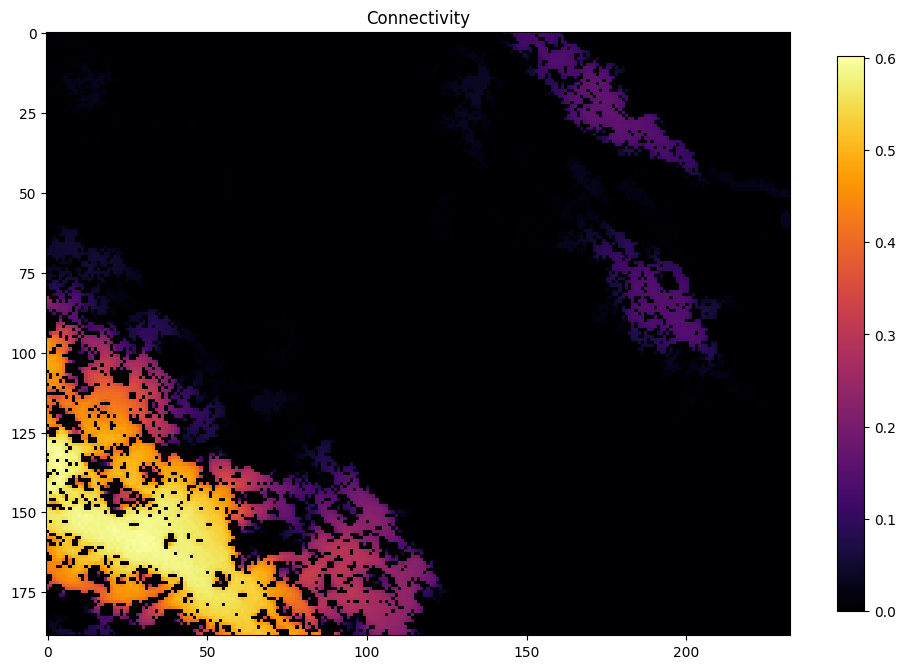

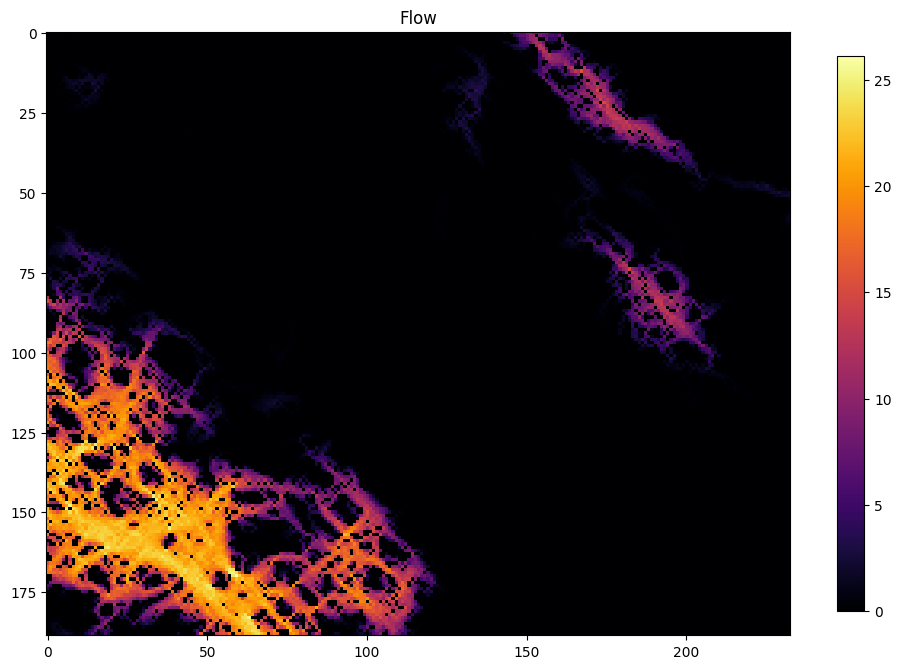

In [11]:
t0 = time.time()
ecoscape_connectivity.compute_connectivity_v2(
    habitat_fn=HABITAT_PATH,
    landcover_fn=LANDCOVER_PATH,
    permeability_dict=permeability_dict,
    connectivity_fn=CONNECTIVITY_PATH,
    flow_fn=FLOW_PATH,
    single_tile=True,
    border_size=50,
    num_simulations=2000,
    include_border=False,
    dispersal=50, # ecoscape_connectivity.half_cauchy(10, 40),
    device=device
)
print("Time:", time.time() - t0)
with GeoTiff.from_file(CONNECTIVITY_PATH) as single_connectivity:
# single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title="Connectivity")
with GeoTiff.from_file(FLOW_PATH) as single_flow:
# single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title="Flow")

## Version v

New


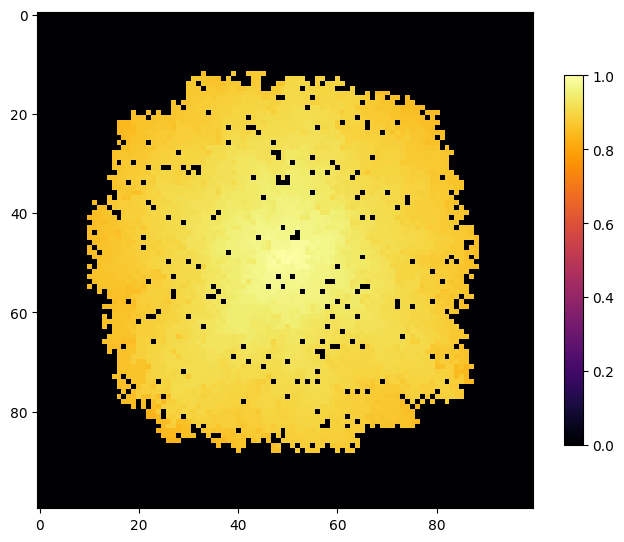

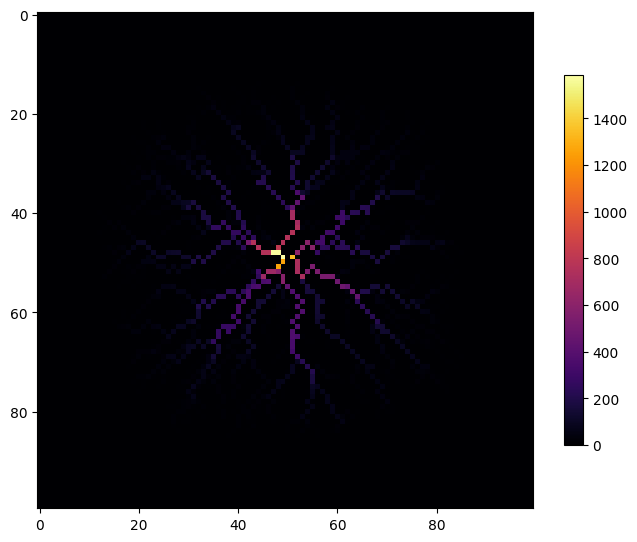

In [6]:

hab = torch.ones((100, 100), device=device)
ter = torch.ones((100, 100), device=device)
repopulator = ecoscape_connectivity.RandomPropagate_v(
    hab, ter, 
    num_spreads=40, 
    spread_size=1, device=device).to(device)
seeds = torch.zeros((100, 100))
seeds[50, 50] = 1
seeds = seeds.to(device)
pop = repopulator(seeds)
a = pop.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(a, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()
tot_pop = pop.sum()
tot_pop.backward()
flow = repopulator.get_grad()
flow = flow.cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(flow, cmap='inferno')
plt.colorbar(shrink=0.6)
plt.show()


Single tile
New
Time: 164.5379409790039
(1, 189, 233)


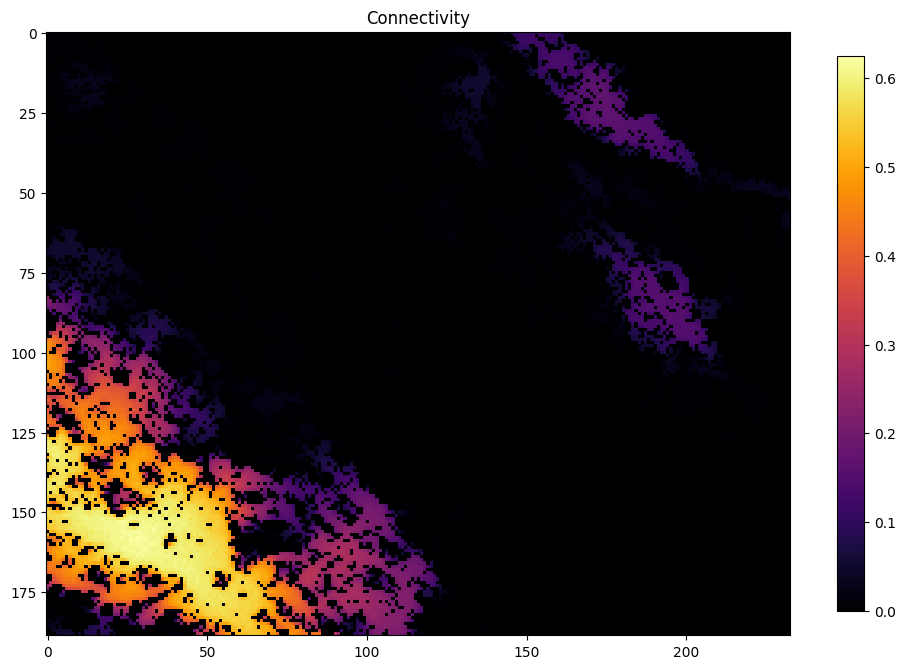

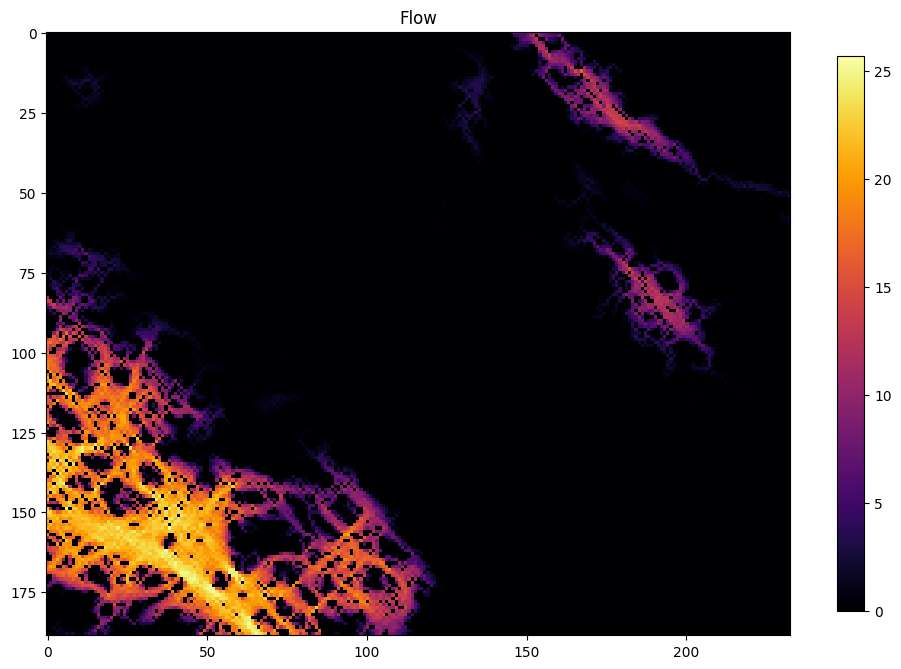

In [8]:
t0 = time.time()
ecoscape_connectivity.compute_connectivity_v(
    habitat_fn=HABITAT_PATH,
    landcover_fn=LANDCOVER_PATH,
    permeability_dict=permeability_dict,
    connectivity_fn=CONNECTIVITY_PATH,
    flow_fn=FLOW_PATH,
    single_tile=True,
    border_size=50,
    num_simulations=2000,
    include_border=False,
    dispersal=50, # ecoscape_connectivity.half_cauchy(10, 40),
)
print("Time:", time.time() - t0)
with GeoTiff.from_file(CONNECTIVITY_PATH) as single_connectivity:
# single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title="Connectivity")
with GeoTiff.from_file(FLOW_PATH) as single_flow:
# single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title="Flow")

## Infinite flips

## Version comparison

## Original

Time: 84.8855471611023
(1, 189, 233)


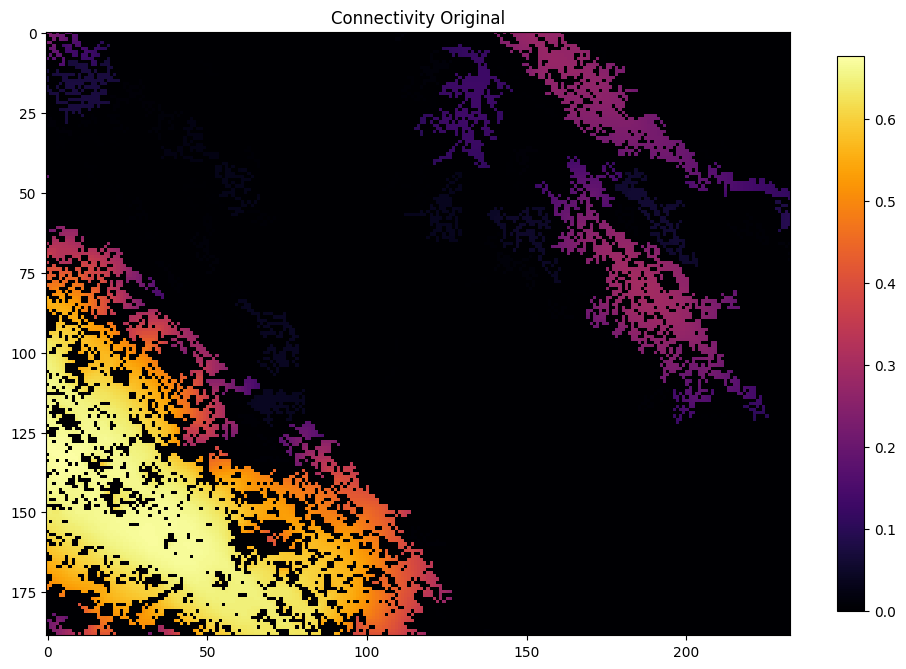

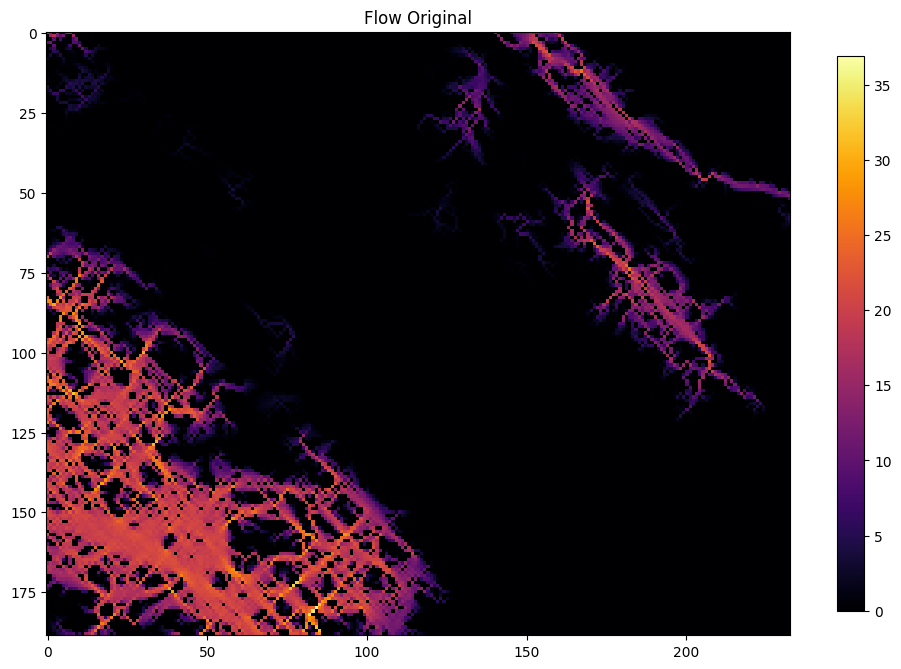

## Single coin flip

Time: 104.7152087688446
(1, 189, 233)


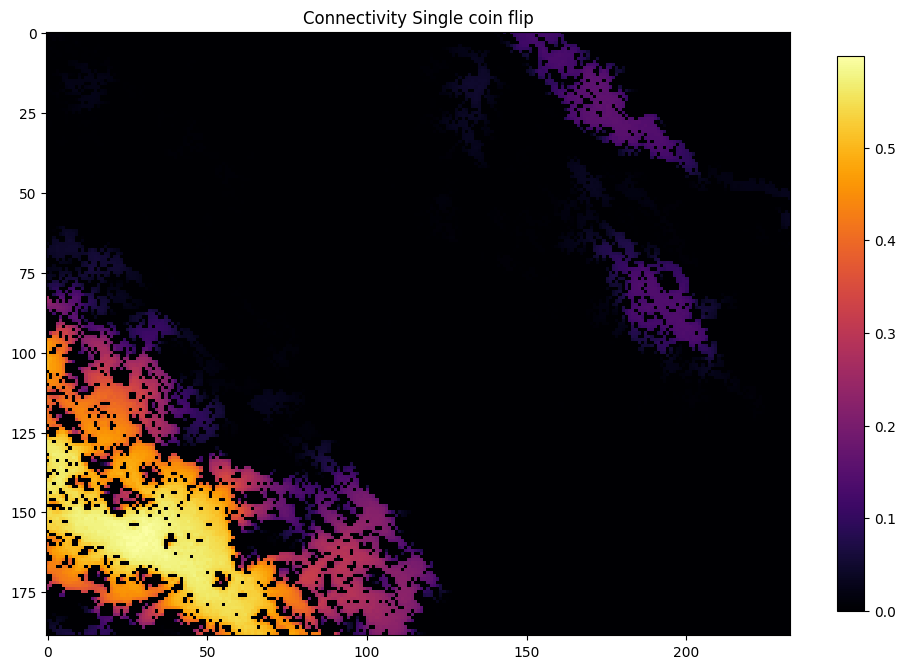

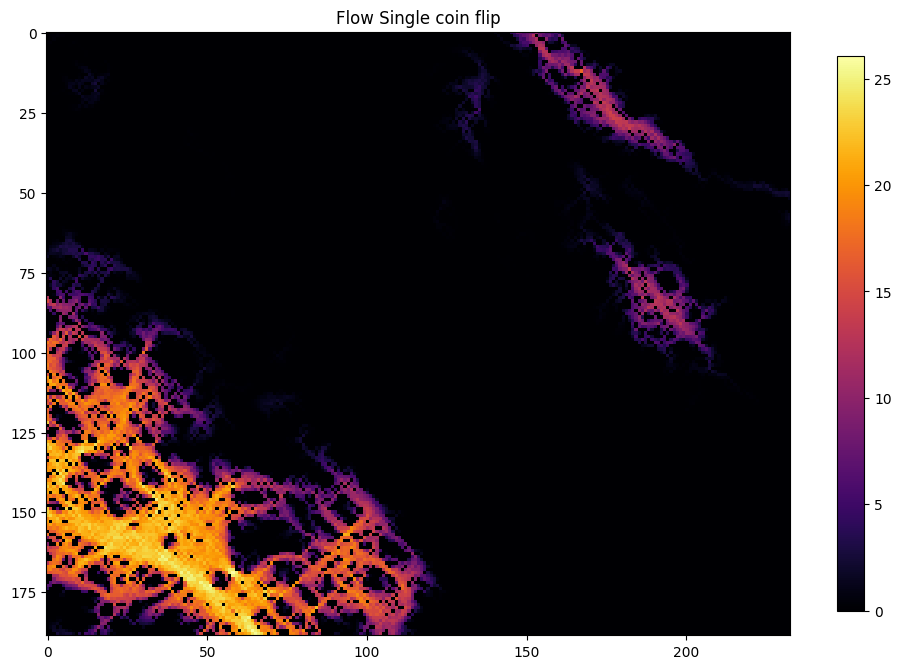

## Two coin flips

New
Time: 116.98153591156006
(1, 189, 233)


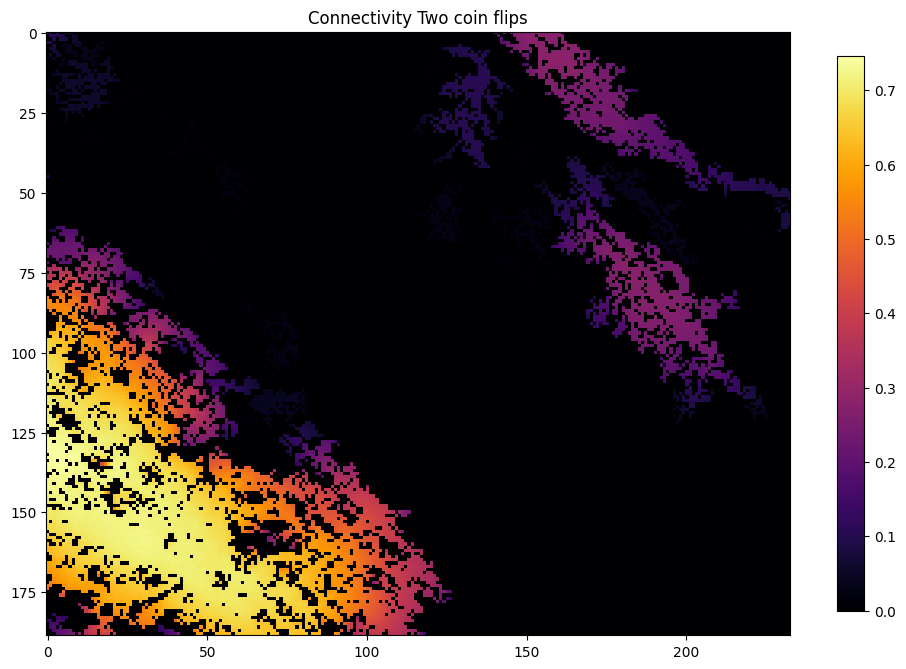

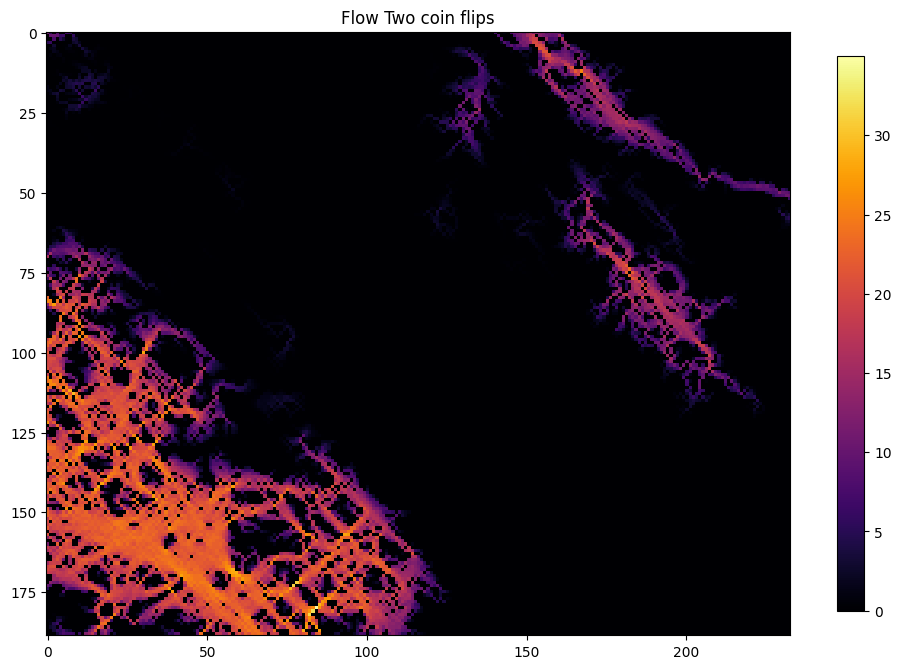

In [6]:
from IPython.display import display, Markdown
algos = ["compute_connectivity_orig", "compute_connectivity_v2", "compute_connectivity_v3"]
titles = {
    "compute_connectivity_orig": "Original",
    "compute_connectivity_v2": "Single coin flip",
    "compute_connectivity_v3": "Two coin flips",
}

for algo in algos:
    display(Markdown(f"## {titles[algo]}"))
    t0 = time.time()
    alg = getattr(ecoscape_connectivity, algo)
    alg(
        habitat_fn=HABITAT_PATH,
        landcover_fn=LANDCOVER_PATH,
        permeability_dict=permeability_dict,
        connectivity_fn=CONNECTIVITY_PATH,
        flow_fn=FLOW_PATH,
        single_tile=True,
        border_size=50,
        num_simulations=2000,
        include_border=False,
        dispersal=50,
    )
    print("Time:", time.time() - t0)
    single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title=f"Connectivity {titles[algo]}")
    single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title=f"Flow {titles[algo]}")